# Exercise Sheet 5

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist  # MNIST data
# from tensorflow.python.keras.utils import to_categorical
# from tensorflow.python.keras.losses import categorical_crossentropy #loss function
# from tensorflow.python.keras.optimizers import Adam, SGD #optimisers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy #loss function
from tensorflow.keras.optimizers import Adam, SGD #optimisers

## [1] MNIST - Conv2D

The digits in the MNIST dataset are in the center. Here we will undo this operation and compare the performance of convolutional neural networks vs fully connected networks.  
* Create a new dataset of size 50x50 where you place the handwritten digit at different random positions in the dataset.
* Now train a neural network with a single hidden dense layer (as on the original MNIST dataset in the lectures).
* Now try to improve your performance in comparison to your previous layout by using an architecture involving convolutional layers (Conv2D).
* $\star$ We have mentioned various options to improve the performance of networks. Check whether methods like Dropout, BatchNormalization, Pooling layers can improve your results. Try to fine-tune the performance (you may also try deeper architectures, i.e. with more hidden layers.)

### Solution

For a very accessible explanation of CNNs, see e.g. [link](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/).  

You can have a look at some architectures in the literature:  
[LeNet5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)  
[GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf)

See also: [Why is training loss higher than testing loss?](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss)  
Very useful when training takes long: [Keras Callbacks](https://keras.io/callbacks/)

Fun stuff about fruit flies: [link](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0205043)

Copy code from lecture

In [8]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


Set up some code for random positioning in a 50x50 initialized with 0

In [9]:
picx = 28
picy = 28
bigpicx = 50
bigpicy = 50

def embed(pic, pos):
    # pos expects a tuple of slice objects
    bigpic = np.zeros((bigpicx, bigpicy))
    bigpic[pos] = pic
    return bigpic

def randpos():
    xpos = np.random.randint(0, (bigpicx-picx))
    ypos = np.random.randint(0, (bigpicy-picy))
    # we use np.s_ to return a tuple of slice objects
    return np.s_[xpos:xpos+picx, ypos:ypos+picy]

Create the dataset

In [10]:
# the final processing of the data is quite compact using list comprehensions
x_train_original = x_train
x_test_original = x_test
x_train = np.array([embed(pic, randpos()) for pic in x_train])
x_test = np.array([embed(pic, randpos()) for pic in x_test])
x_train_conv = np.expand_dims(x_train, axis=3)
x_test_conv = np.expand_dims(x_test, axis=3)
x_train_original_conv = np.expand_dims(x_train_original, axis=3)
x_test_original_conv = np.expand_dims(x_test_original, axis=3)

#### Try with only dense layers:

In [11]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(250, activation='relu'))
model1.add(tf.keras.layers.Dense(10, activation='softmax'))
model1.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 7s 119us/sample - loss: 0.2803 - accuracy: 0.9197 - val_loss: 0.3730 - val_accuracy: 0.8889
Epoch 2/3
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2242 - accuracy: 0.9377 - val_loss: 0.3554 - val_accuracy: 0.8911
Epoch 3/3
60000/60000 [==============================] - 7s 115us/sample - loss: 0.1814 - accuracy: 0.9509 - val_loss: 0.3502 - val_accuracy: 0.8955


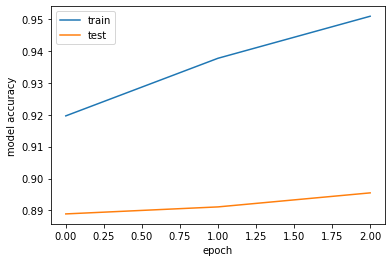

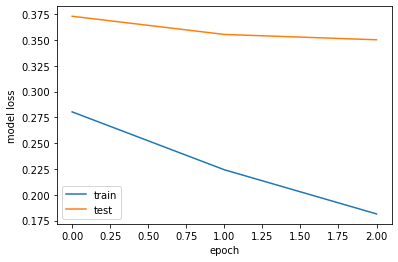

In [14]:
batch_size = 128
epochs = 3

hist1 = model1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

The result is not bad, training is fast, but it is hard to go significantly beyond 90% accuracy on the test data

#### Now also add convolutional layers

In [15]:
model_conv1 = tf.keras.Sequential()

# Convolutional preprocessing
model_conv1.add(tf.keras.layers.Conv2D(16, (5,5), input_shape=(50,50,1), activation='relu'))
model_conv1.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model_conv1.add(tf.keras.layers.Conv2D(16, (5,5), input_shape=(50,50,1), activation='relu'))
model_conv1.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Flatten to prepare for dense layers
model_conv1.add(tf.keras.layers.Flatten())

# Dense postprocessing
model_conv1.add(tf.keras.layers.Dense(648, activation='relu'))

model_conv1.add(tf.keras.layers.Dense(10, activation='softmax'))

model_conv1.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model_conv1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 648)               840456    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 114s 2ms/sample - loss: 0.5674 - accuracy: 0.8122 - val_loss: 0.1741 - val_accuracy: 0.9452
Epoch 2/3
60000/60000 [==============================] - 110s 2ms/sample - loss: 0.1469 - accuracy: 0.9555 - val_loss: 0.1094 - val_accuracy: 0.9650
Epoch 3/3
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.0902 - accuracy: 0.9714 - val_loss: 0.1164 - val_accuracy: 0.9644


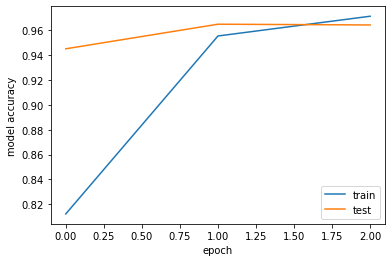

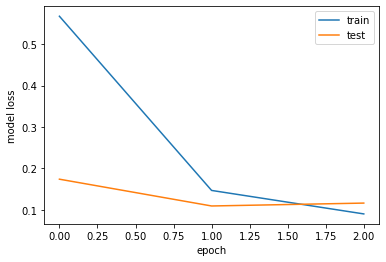

In [16]:
batch_size = 128
epochs = 3

hist_conv1 = model_conv1.fit(x_train_conv, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_conv, y_test))

# summarize history for accuracy
plt.plot(hist_conv1.history['accuracy'])
plt.plot(hist_conv1.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(hist_conv1.history['loss'])
plt.plot(hist_conv1.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Try another architecture

In [17]:
model_conv2 = tf.keras.Sequential()

# Convolutional preprocessing
model_conv2.add(tf.keras.layers.Conv2D(64, (7,7), input_shape=(50,50,1), activation='relu'))
model_conv2.add(tf.keras.layers.MaxPooling2D(pool_size=3))
model_conv2.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model_conv2.add(tf.keras.layers.MaxPooling2D(pool_size=3))
model_conv2.add(tf.keras.layers.Conv2D(192, (3,3), activation='relu'))
model_conv2.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Flatten to prepare for dense layers
model_conv2.add(tf.keras.layers.Flatten())

# Dense postprocessing
model_conv2.add(tf.keras.layers.Dense(128, activation='relu'))

model_conv2.add(tf.keras.layers.Dense(10, activation='softmax'))

model_conv2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model_conv2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 44, 44, 64)        3200      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 192)         221376    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 192)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 192)              

In [ ]:
batch_size = 128
epochs = 3

hist_conv2 = model_conv2.fit(x_train_conv, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_conv, y_test))

# summarize history for accuracy
plt.plot(hist_conv2.history['acc'])
plt.plot(hist_conv2.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(hist_conv2.history['loss'])
plt.plot(hist_conv2.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Add batch normalization and dropout.

In [18]:
model_conv3 = tf.keras.Sequential()

# Convolutional preprocessing
model_conv3.add(tf.keras.layers.Conv2D(64, (7,7), input_shape=(50,50,1), use_bias=False))
model_conv3.add(tf.keras.layers.BatchNormalization())
model_conv3.add(tf.keras.layers.Activation('relu'))

model_conv3.add(tf.keras.layers.MaxPooling2D(pool_size=3))

model_conv3.add(tf.keras.layers.Conv2D(128, (3,3), use_bias=False))
model_conv3.add(tf.keras.layers.BatchNormalization())
model_conv3.add(tf.keras.layers.Activation('relu'))

model_conv3.add(tf.keras.layers.MaxPooling2D(pool_size=3))

model_conv3.add(tf.keras.layers.Conv2D(192, (3,3), use_bias=False))
model_conv3.add(tf.keras.layers.BatchNormalization())
model_conv3.add(tf.keras.layers.Activation('relu'))
model_conv3.add(tf.keras.layers.Dropout(0.5))

model_conv3.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Flatten to prepare for dense layers
model_conv3.add(tf.keras.layers.Flatten())

# Dense postprocessing
model_conv3.add(tf.keras.layers.Dense(128, use_bias=False))
model_conv3.add(tf.keras.layers.BatchNormalization())
model_conv3.add(tf.keras.layers.Activation('relu'))

model_conv3.add(tf.keras.layers.Dense(10, activation='softmax'))

model_conv3.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model_conv3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 44, 44, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73728     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 12, 128)      

In [19]:
batch_size = 64
epochs = 2

hist_conv3 = model_conv3.fit(x_train_conv, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_conv, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 544s 9ms/sample - loss: 0.2963 - accuracy: 0.9105 - val_loss: 0.1538 - val_accuracy: 0.9531
Epoch 2/2
60000/60000 [==============================] - 654s 11ms/sample - loss: 0.0874 - accuracy: 0.9732 - val_loss: 0.1291 - val_accuracy: 0.9573


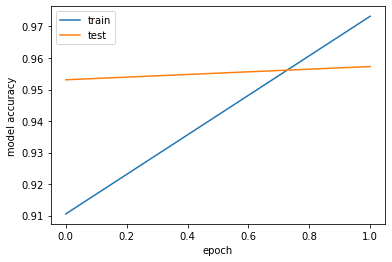

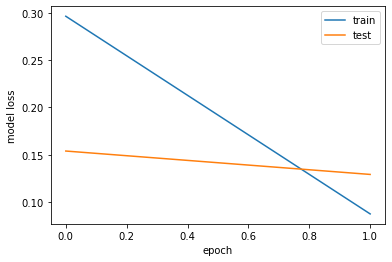

In [21]:

# summarize history for accuracy
plt.plot(hist_conv3.history['accuracy'])
plt.plot(hist_conv3.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(hist_conv3.history['loss'])
plt.plot(hist_conv3.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()